# Long Sentence Resolution - Run Solution Recipe (v2)

# Documentation

## Connect Google Drive

*   Run the cell "Connect Google Drive" and on the popup window click  "Connect to Google Drive".

*   In the new page opened, choose an account (your account) and click Allow.

## Configuration parameters

* **Shortening model checkpoint**: The shortening model checkpoint to load (default: shortening_model_2022-11-18-08-26-03/checkpoint-1189).

* **Splitting model checkpoint**: The splitting model checkpoint to load (default: splitting_model_2022-10-27-15-34-55/checkpoint-135954).

* **Target maximum #words**: The maximum number of words a sentence should have to be considered a valid target sentence (default: 15).

* **Shortening/Splitting #words threshold**: When the #words in a sentence is less than or equal to the threshold, shortening is applied to it. Otherwise, splitting is applied (default: 21).

* **Long sentences to resolve**: The long sentences to be resolved. Each line in the text area should have only one sentence.

## Models

Model ID | Model best checkpoint | Model base checkpoint | Dataset ID (trained on) | Model task | Model architecture | Dataset sources | Tasks of dataset sources
:- | :- | :- | :- | :- | :- | :- | :-
shortening_model_2022-10-24-08-53-31 | checkpoint-90000 | facebook/bart-large | shortening_dataset_2022-10-20-10-12-03 | Sentence Compression | BART | Google sentence compression dataset | Sentence Compression
shortening_model_2022-10-21-08-59-07 | checkpoint-2650 | facebook/bart-large | shortening_dataset_2022-10-20-10-26-09 | Sentence Compression | BART | QQP, MRPC, PAWS | Paraphrasing
shortening_model_2022-11-17-14-40-25 | checkpoint-5945 | facebook/bart-large | shortening_dataset_2022-11-17-13-27-27 | Sentence Compression | BART | Google sentence compression dataset, QQP, MRPC, PAWS | Sentence Compression, Paraphrasing
shortening_model_2022-11-18-08-26-03 | checkpoint-1189 | shortening_model_2022-10-21-21-08-16/checkpoint-61551 | shortening_dataset_2022-11-17-13-27-27 | Sentence Compression | BART | Google sentence compression dataset, QQP, MRPC, PAWS | Sentence Compression, Paraphrasing
shortening_model_2022-10-21-21-08-16 | checkpoint-61551 | facebook/bart-large | shortening_dataset_2022-10-20-11-03-23 | Sentence Compression | BART | Google sentence compression dataset, QQP, MRPC, PAWS | Sentence Compression, Paraphrasing
shortening_model_2022-10-17-11-14-41 | checkpoint-300000 | facebook/bart-large | shortening_dataset_2022-10-17-08-29-25 | Sentence Compression | BART | Gigaword, DUC 2004, Google sentence compression dataset, QQP, MRPC, PAWS | Summarization, Sentence Compression, Paraphrasing
splitting_model_2022-10-26-09-29-01 | checkpoint-55230 | facebook/bart-large | splitting_dataset_2022-10-20-11-08-22 | Split and Rephrase | BART | WikiSplit | Split and Rephrase
splitting_model_2022-10-27-06-27-03 | checkpoint-53112 | facebook/bart-large | splitting_dataset_2022-10-20-11-12-34 | Split and Rephrase | BART | BiSECT | Split and Rephrase
splitting_model_2022-10-27-15-34-55 | checkpoint-135954 | facebook/bart-large | splitting_dataset_2022-10-20-11-14-41 | Split and Rephrase | BART | WikiSplit, BiSECT | Split and Rephrase
splitting_model_2022-10-27-10-15-31 | N/A | N/A | splitting_dataset_2022-10-20-11-14-41 | Split | Baseline | WikiSplit, BiSECT | Split and Rephrase

## Solution recipe flowchart (for a single sentence)

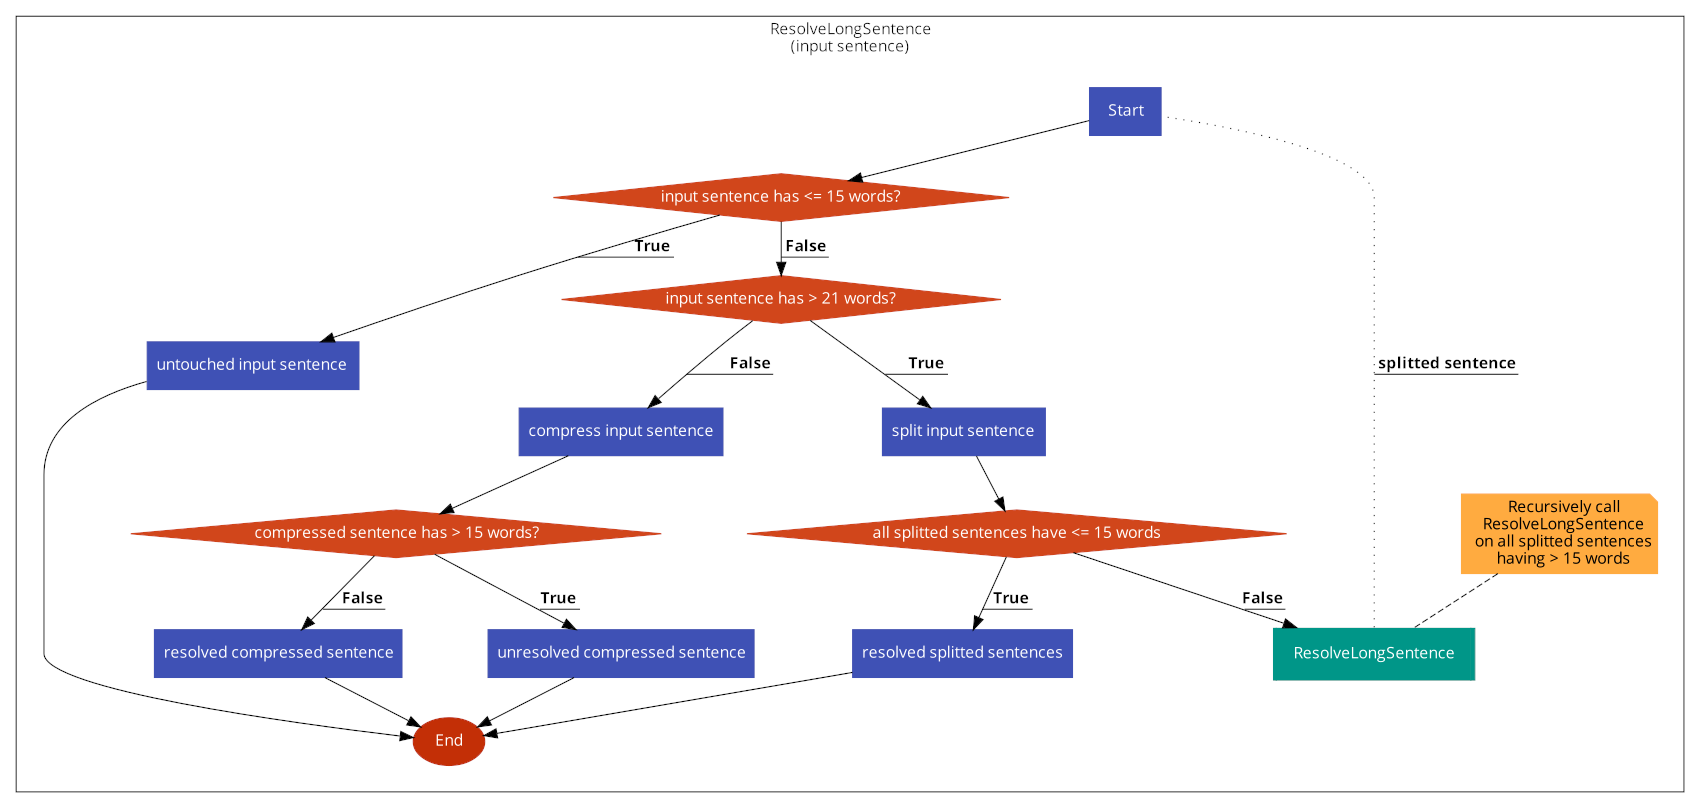

# Installations

In [ ]:
!pip install transformers==4.23.1 \
             spacy==3.4.1

# Imports

In [ ]:
import os, torch, glob

import pandas as pd

import numpy as np

import ipywidgets as widgets

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

from pathlib import Path

from typing import List, Union, Tuple

from google.colab import drive

from spacy.lang.en import English

from spacy.tokens import Doc, Token, Span

# Functions / Classes

In [ ]:
class DocumentAnalysis:
  def __init__ (self):
    self._linguistics_model = English()

    self._linguistics_model.add_pipe("sentencizer")

  def extract_n_words_from_texts(self, texts: Union[List[str], np.ndarray, pd.Series]) -> np.ndarray:
    return np.array(list(map(self._extract_n_words_from_document_or_span, self._linguistics_model.pipe(texts, batch_size=50))))

  def extract_n_words_from_text(self, text: str) -> int:
    return self._extract_n_words_from_document_or_span(self._linguistics_model(text))

  def extract_sentence_n_words_from_text(self, text: str) -> List[int]:
    return list(map(self._extract_n_words_from_document_or_span, self._linguistics_model(text).sents))

  def extract_sentences_from_text(self, text: str) -> List[str]:
    return list(map(lambda o: o.text, self._linguistics_model(text).sents))

  def _extract_n_words_from_document_or_span(self, input: Union[Span, Doc]) -> int:
    return sum(map(self._token_is_word, input))

  def _token_is_word(self, token: Token) -> bool:
    return not any([ token.is_bracket,
                     token.is_punct,
                     token.is_currency,
                     token.is_quote,
                     token.is_space ]) # https://spacy.io/api/token#attributes

class ShorteningInference:
  def __init__ (self, checkpoint_path: Union[Path, str]):
    self._device = "cuda:0" if torch.cuda.is_available() else "cpu"

    self._model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path).to(self._device)

    self._tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

  def generate(self, sentences: List[str], batch_size: int) -> List[str]:
    sentences = list(map(str.strip, sentences))

    shortened_sentences = []

    for i in range(0, len(sentences), batch_size):
      model_inputs = self._tokenizer(sentences[i : i + batch_size], padding=True, truncation=True, return_tensors='pt').to(self._device)

      sequences = self._model.generate(**model_inputs, max_length=1000, num_beams=2)

      outputs = self._tokenizer.batch_decode(sequences, skip_special_tokens=True)

      shortened_sentences.extend(outputs)

    return shortened_sentences

class SplittingInference:
  def __init__ (self, checkpoint_path: Union[Path, str]):
    self._device = "cuda:0" if torch.cuda.is_available() else "cpu"

    self._model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_path).to(self._device)

    self._tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

  def generate(self, sentences: List[str], batch_size: int) -> List[str]:
    sentences = list(map(str.strip, sentences))

    splitted_sentences = []

    for i in range(0, len(sentences), batch_size):
      model_inputs = self._tokenizer(sentences[i : i + batch_size], padding=True, truncation=True, return_tensors='pt').to(self._device)

      sequences = self._model.generate(**model_inputs, max_length=1000, num_beams=2)

      outputs = self._tokenizer.batch_decode(sequences, skip_special_tokens=True)

      splitted_sentences.extend(outputs)

    return splitted_sentences

class LongSentenceResolution:
  def __init__(self, shortening_inference: ShorteningInference, splitting_inference: SplittingInference, document_analysis: DocumentAnalysis):
    self._shortening_inference = shortening_inference

    self._splitting_inference = splitting_inference

    self._document_analysis = document_analysis

    self._maximum_recursion_depth = 10

  def _define_final_resolution_state(self, states: List[str]) -> str:
    if all(map(lambda o: o == 'resolved', states)):
      return 'resolved'
    elif all(map(lambda o: o == 'unresolved', states)):
      return 'unresolved'
    elif 'unresolved' in states:
      return 'partially resolved'
    else:
      return 'untouched'

  def _resolve_sentence(self, input_sentence: str, target_maximum_n_words: int, n_words_threshold: int, current_recursion_depth: int, collected_resolutions: List[Tuple[str, int, str, str]]) -> List[Tuple[str, int, str, str]]:
    input_sentence_n_words = self._document_analysis.extract_n_words_from_text(input_sentence)

    if current_recursion_depth >= self._maximum_recursion_depth:
      collected_resolutions.append((input_sentence, input_sentence_n_words, 'splitting', 'unresolved'))
    elif input_sentence_n_words <= target_maximum_n_words:
      collected_resolutions.append((input_sentence, input_sentence_n_words, 'none', 'untouched'))
    elif input_sentence_n_words <= n_words_threshold:
      shortening_result = self._shortening_inference.generate([input_sentence], batch_size=1) [0]

      shortening_result_n_words = self._document_analysis.extract_n_words_from_text(shortening_result)

      collected_resolutions.append((shortening_result, shortening_result_n_words, 'shortening', 'resolved' if shortening_result_n_words <= target_maximum_n_words else 'unresolved'))
    else:
      splitting_result = self._splitting_inference.generate([input_sentence], batch_size=1) [0]

      for sentence, n_words in zip(self._document_analysis.extract_sentences_from_text(splitting_result), self._document_analysis.extract_sentence_n_words_from_text(splitting_result)):
        if n_words > target_maximum_n_words:
          self._resolve_sentence(sentence, target_maximum_n_words, n_words_threshold, current_recursion_depth + 1, collected_resolutions)
        else:
          collected_resolutions.append((sentence, n_words, 'splitting', 'resolved'))

    return list(zip(*collected_resolutions))

  def resolve(self, sentences: List[str], target_maximum_n_words: int, n_words_threshold: int) -> pd.DataFrame:
    sentences = list(map(str.strip, sentences))

    sentences_df = pd.DataFrame(sentences, columns = ['input_sentence'])

    sentences_df['input_sentence_n_words'] = self._document_analysis.extract_n_words_from_texts(sentences_df['input_sentence'])

    sentences_df[['resolution', 'resolution_n_words', 'method', 'state']] = sentences_df.apply(lambda row: self._resolve_sentence(row['input_sentence'], target_maximum_n_words, n_words_threshold, current_recursion_depth=0, collected_resolutions=[]), axis=1, result_type='expand')

    sentences_df['state'] = sentences_df['state'].apply(self._define_final_resolution_state)

    sentences_df['resolution'] = sentences_df['resolution'].apply(" ".join)

    return sentences_df

def load_selections_for_shortening_model_dropdown (data_path: Path) -> List[str]:
  return list(map(lambda o: str(Path(os.path.basename(os.path.dirname(o))) / os.path.basename(o)), glob.glob(str(data_path / 'shortening_model_*' / 'checkpoint-*' ))))

def load_selections_for_splitting_model_dropdown (data_path: Path) -> List[str]:
  return list(map(lambda o: str(Path(os.path.basename(os.path.dirname(o))) / os.path.basename(o)), glob.glob(str(data_path / 'splitting_model_*' / 'checkpoint-*' ))))

# Connect Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

# Create paths

In [ ]:
MODELS_DIRECTORY_PATH = Path('/content/drive/My Drive/Pfizer - Long Sentence Resolution/Models')

# Configuration parameters

In [ ]:
long_sentence_examples = [
  "Now, 17 years later, we are in the midst of a pandemic caused by a related coronavirus.",
  "People infected with the virus should receive medical treatment to relieve and alleviate the symptoms they are experiencing.",
  "Still, for some, the details of what clinical trials do and how they work may not be clear.",
  "Rady's experience as a parent of a child living with an intellectual disability shifted his world view.",
  "Still, partly due to limitations of available research, many Asian American ethnic groups have not been represented in...",
  "Like HBV, sexual intercourse can also spread Hepatitis C virus (HCV), which is carried by blood, semen, and other bodily fluid.",
  "Worldwide communities have increasing expectations for a better lifestyle, to be delivered from a planet with finite resources, which are depleting.",
  "Additionally, safety was evaluated through a randomized, placebo-controlled, dose-ranging trial and an ongoing long-term open-label extension trial.",
  "From the pandemic to political and racial unrest, it all can be a lot to handle.",
  "If you feel that something’s not right with your health, pursue it and speak up for yourself.",
  "Detailed information on our financial and operational performance can be found in our 2021 Annual Report on Form 10-K.",
  "We strive to set the standard for quality, safety and value in the discovery, development and manufacture of health care products.",
  "Blakemore recently tapped into her creativity when helping to design a new medicine to treat NASH (non-alcoholic steatohepatitis), the most severe form of fatty-liver disease.",
  "These strategies slowed spread of the novel coronavirus, but also caused parents and healthcare providers to postpone doctors’ appointments and well-child visits.",
  "In the LTE study, patients who had been treated with VYNDAQEL 80 mg continued this therapy, then transitioned to the bioequivalent single-capsule VYNDAMAX.",
  "The future of medicine is happening at Pfizer, and we’re eager to work alongside inspired and inspirational people who want to improve healthcare around the world.",
  "It has the power to spark charged discussions for anyone talking about the topic—whether they’re in favor of vaccines, opposed to vaccines or somewhere in the middle.",
  "BioNTech SE and Pfizer Inc. today announced that preliminary, peer-reviewed data from their ongoing German Phase 1/2 Study of BNT162b1 were published online in the journal Nature.",
  "In connection with the proposed transaction, Biohaven will be filing documents with the SEC, including preliminary and definitive proxy statements relating to the proposed transaction.",
  "Through coordinated contributions from multiple partners, including Pfizer’s support training teams to handle and store the vaccine, the Central Medical Stores central warehouse, and 12 regional government warehouses store, manage, and deliver the vaccine.",
  "Additionally, Pfizer's Global Security team partners with the law enforcement community to identify counterfeit medications and respond to reports of counterfeits."
]

shortening_model_dropdown = widgets.Dropdown(options=load_selections_for_shortening_model_dropdown(MODELS_DIRECTORY_PATH), value='shortening_model_2022-11-18-08-26-03/checkpoint-1189', layout={'width': '500px'})
splitting_model_dropdown = widgets.Dropdown(options=load_selections_for_splitting_model_dropdown(MODELS_DIRECTORY_PATH), value='splitting_model_2022-10-27-15-34-55/checkpoint-135954', layout={'width': '500px'})
target_maximum_n_words_bounded_int_text = widgets.BoundedIntText(value=15, min=1, max=20, step=1)
shortening_splitting_n_words_threshold_bounded_int_text = widgets.BoundedIntText(value=21, min=1, max=100, step=1)
long_sentences_to_resolve_textarea = widgets.Textarea(placeholder='Type here long sentences to resolve.', value='\n'.join(long_sentence_examples), layout={'height': '300px', 'width': '600px'})

display(widgets.HBox([widgets.Label(value="Shortening model checkpoint:"), shortening_model_dropdown]))
display(widgets.HBox([widgets.Label(value="Splitting model checkpoint:"), splitting_model_dropdown]))
display(widgets.HBox([widgets.Label(value="Target maximum #words:"), target_maximum_n_words_bounded_int_text]))
display(widgets.HBox([widgets.Label(value="Shortening/Splitting #words threshold:"), shortening_splitting_n_words_threshold_bounded_int_text]))
display(widgets.HBox([widgets.Label(value="Long sentences to resolve:"), long_sentences_to_resolve_textarea]))

# Create dependencies

In [ ]:
document_analysis = DocumentAnalysis()

shortening_inference = ShorteningInference(MODELS_DIRECTORY_PATH / shortening_model_dropdown.value)

splitting_inference = SplittingInference(MODELS_DIRECTORY_PATH / splitting_model_dropdown.value)

long_sentence_resolution = LongSentenceResolution(shortening_inference=shortening_inference, splitting_inference=splitting_inference, document_analysis=document_analysis)

# Resolve long sentences with shortening

In [ ]:
%%time

shortening_df = pd.DataFrame({'source': long_sentences_to_resolve_textarea.value.split('\n'), 'prediction': shortening_inference.generate(sentences=long_sentences_to_resolve_textarea.value.split('\n'), batch_size=8) })

shortening_df

In [ ]:
shortening_df.to_csv('shortening-results-for-evaluation.csv', index=False)

# Resolve long sentences with splitting

In [ ]:
%%time

splitting_df = pd.DataFrame({'source': long_sentences_to_resolve_textarea.value.split('\n'), 'prediction': splitting_inference.generate(sentences=long_sentences_to_resolve_textarea.value.split('\n'), batch_size=8) })

splitting_df

In [ ]:
splitting_df.to_csv('splitting-results-for-evaluation.csv', index=False)

# Solution Recipe

In [ ]:
%%time

solution_df = long_sentence_resolution.resolve(sentences=long_sentences_to_resolve_textarea.value.split('\n'),
                                               target_maximum_n_words=target_maximum_n_words_bounded_int_text.value,
                                               n_words_threshold=shortening_splitting_n_words_threshold_bounded_int_text.value)

In [ ]:
solution_df[['input_sentence', 'input_sentence_n_words', 'resolution', 'resolution_n_words', 'method', 'state']]

In [ ]:
solution_df[['input_sentence', 'input_sentence_n_words', 'resolution', 'resolution_n_words', 'method', 'state']].to_csv('solution-recipe-results-for-evaluation.csv', index=False)